In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# SVD compressing

In [2]:
import imageio

im = imageio.imread_v2('40.jpg')
print(im.shape)

(800, 800, 3)


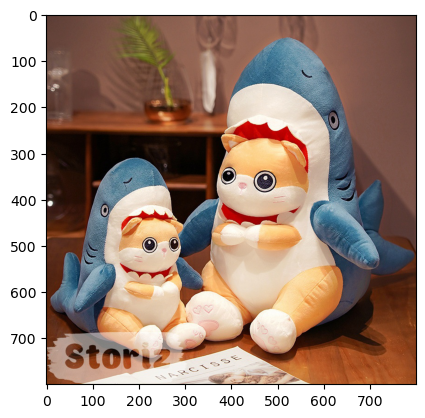

In [3]:
plt.imshow(im)

In [4]:
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

In [5]:
im.ravel?

In [6]:
im_double = im2double(im)

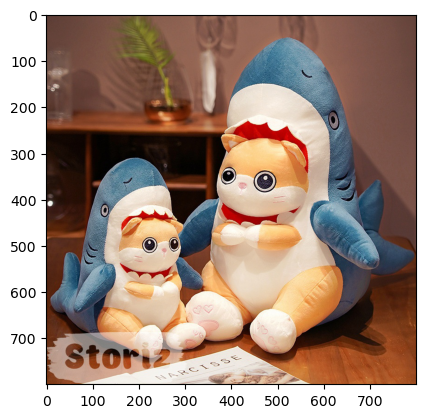

In [7]:
plt.imshow(im_double)

In [8]:
im_double

Array([[[0.36470588, 0.23529412, 0.2       ],
        [0.36862745, 0.23921569, 0.20392157],
        [0.37254902, 0.24313725, 0.20784314],
        ...,
        [0.38823529, 0.25882353, 0.22352941],
        [0.39215686, 0.2627451 , 0.22745098],
        [0.38823529, 0.25882353, 0.22352941]],

       [[0.36470588, 0.23529412, 0.2       ],
        [0.36862745, 0.23921569, 0.20392157],
        [0.36862745, 0.23921569, 0.20392157],
        ...,
        [0.39215686, 0.2627451 , 0.22745098],
        [0.39215686, 0.2627451 , 0.22745098],
        [0.38823529, 0.25882353, 0.22352941]],

       [[0.36470588, 0.23529412, 0.2       ],
        [0.36862745, 0.23921569, 0.20392157],
        [0.36862745, 0.23921569, 0.20392157],
        ...,
        [0.39215686, 0.2627451 , 0.22745098],
        [0.39215686, 0.2627451 , 0.22745098],
        [0.39215686, 0.2627451 , 0.22745098]],

       ...,

       [[0.50196078, 0.25098039, 0.11372549],
        [0.49803922, 0.24705882, 0.10980392],
        [0.49411765, 0

In [9]:
from scipy.linalg import svd

In [10]:
U,s, Vh = svd(im_double[:,:,0])

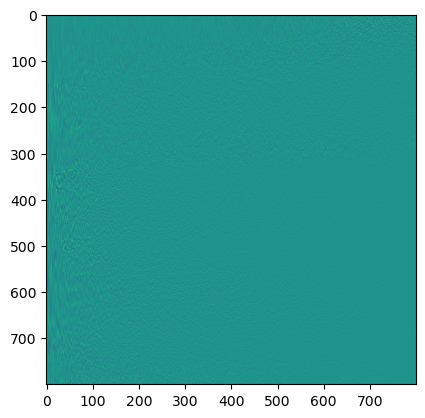

In [11]:
plt.imshow(U)

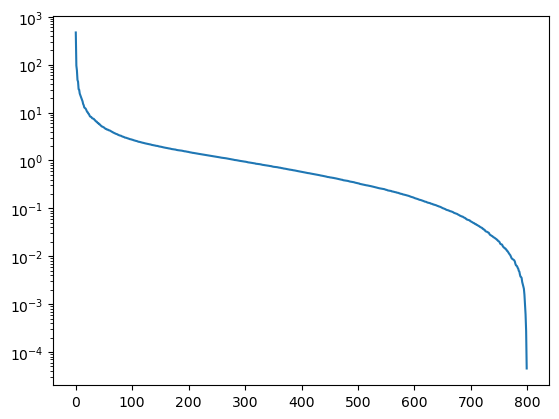

In [12]:
plt.plot(s)
plt.yscale('log')

In [13]:
M = np.zeros((800, 800))

for i in range(800):

    M[i, i] = s[i]

M = np.dot(U, np.dot(M, Vh))

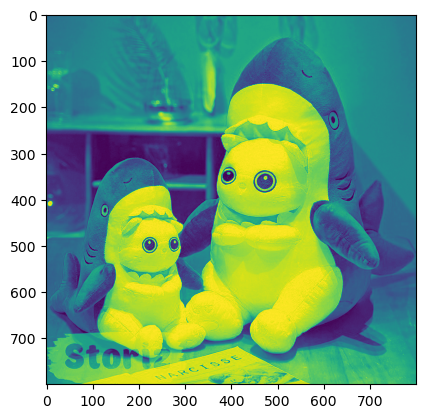

In [14]:
plt.imshow(M)

In [15]:
M = np.zeros((800, 800))

for i in range(200):

    M[i, i] = s[i]

M = np.dot(U, np.dot(M, Vh))

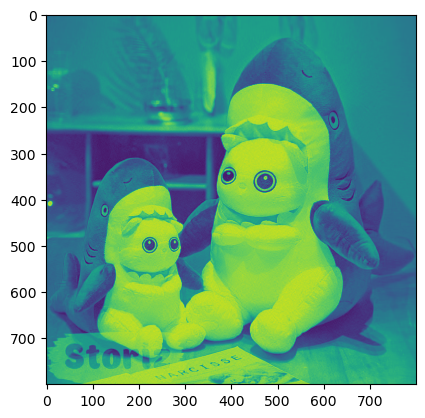

In [16]:
plt.imshow(M)

In [19]:
r_max = 20
M = np.zeros((800, 800,3))
for j in [0,1,2]:
    U,s, Vh = svd(im_double[:,:,j])
    
    a = np.zeros((800, 800))

    for i in range(r_max):
        a[i, i] = s[i]

    a = np.dot(U, np.dot(a, Vh))
    M[:,:,j] = a

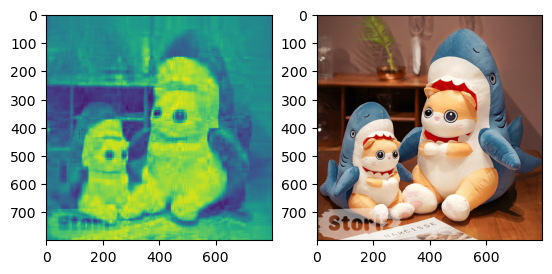

In [20]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(M[:,:,0])
axs[1].imshow(im_double)


# iterative linear 
##   Jakobi iterations

$$
Ax=b \implies x=Bx+c, \; B = D^{-1}(D-A) \; ,c = D^{-1} b \implies ||B||<1
$$

In [242]:
N = 100
A = np.random.uniform(-1,1, N*N).reshape(N,N)
A.shape

(100, 100)

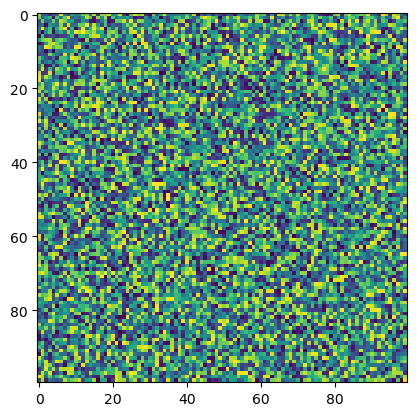

In [243]:
plt.imshow(A)

In [244]:
A+= np.diag(10*np.ones(N))

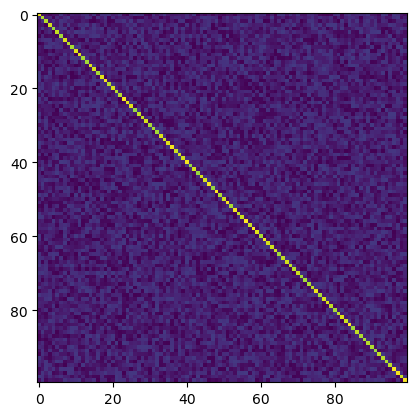

In [245]:
plt.imshow(A)

In [246]:
b = np.random.uniform(-1,1, N)

In [247]:
d = np.diagonal(A)

In [248]:
np.min(d)

9.049081340373268

In [249]:
c = b/d

In [250]:
B = np.diag(1./d)
B = B  @ (np.diag(d)-A)

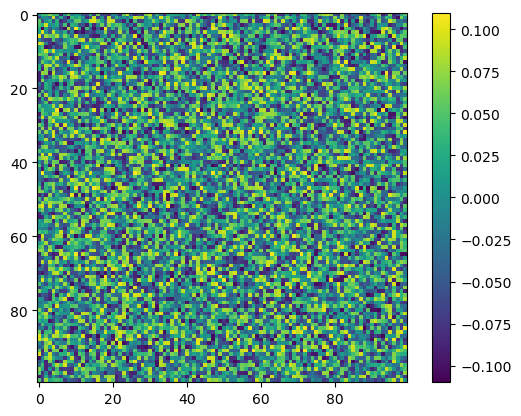

In [251]:
plt.imshow(B)
plt.colorbar()

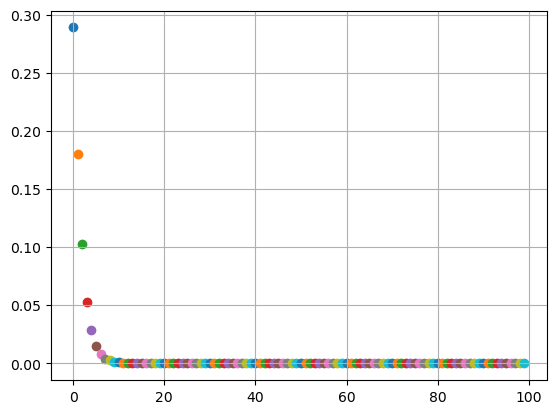

In [252]:
from scipy.linalg import solve
plt.figure()
plt.grid()
x = c.copy()
x_scipy = solve(A,b)
for i in range(100):
    x = B@x + c
    plt.scatter(i, np.linalg.norm(x - x_scipy))

##   Sedile iterations

$$
Ax=b \implies (L+D)x_{n+1} + U x_n = b
$$

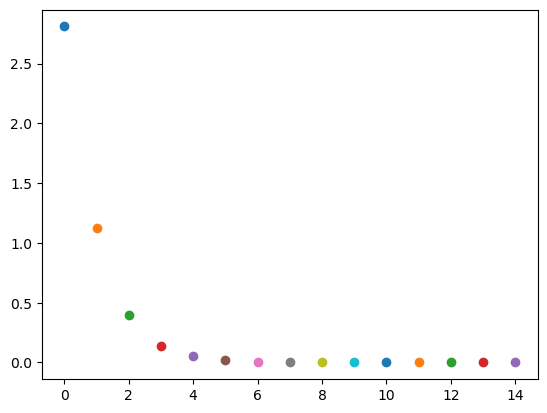

In [253]:
from scipy.linalg import solve_triangular
x0 = b.copy()
x_scipy = solve(A,b)

for i in range(15):
    rhs = b - np.triu(A, k=1) @ x0
    x = solve_triangular(A, rhs, lower=True)
    x0 = x
    plt.scatter(i, np.linalg.norm(x - x_scipy))
    

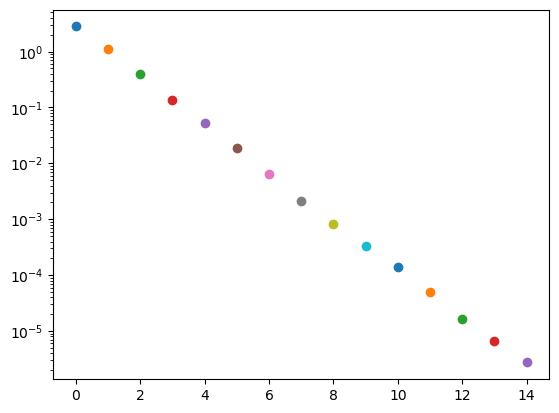

In [254]:
x0 = b.copy()
#A += 5*np.diag(np.ones(N))
x_scipy = solve(A,b)
for i in range(15):
    rhs = b - np.triu(A, k=1) @ x0
    x = solve_triangular(A, rhs, lower=True)
    x0 = x
    plt.scatter(i, np.linalg.norm(x - x_scipy))
plt.yscale('log')    

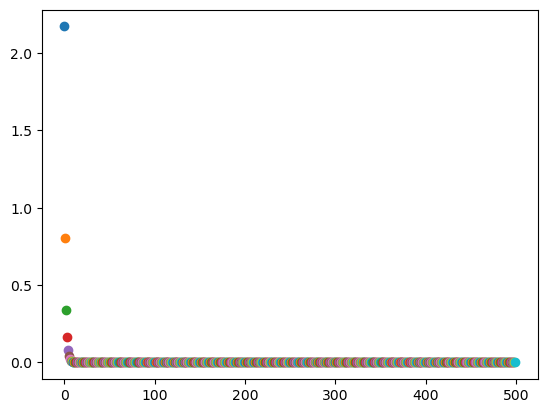

In [239]:
x0 = b.copy()
A += 5*np.diag(np.ones(N))
A_sq = A.T @ A
x_scipy = solve(A_sq, b)
for i in range(500):
    rhs = b - np.triu(A_sq, k=1) @ x0
    x = solve_triangular(A_sq, rhs, lower=True)
    x0 = x
    plt.scatter(i, np.linalg.norm(x - x_scipy))

### Minimal residual sheme
$$
\frac{x_{n+1} - x_{n}}{\tau_{n+1}} + Ax_n =b, ||r_{n+1}||\to \min \implies \tau_{n+1} = \frac{(r_n, Ar_n)}{|Ar_n|^2}
$$

In [240]:
def res(A, b, x0 = None, n_iter=15):
    if x0 is None:
        x0 = np.ones(b.shape[0])
    
    x = x0
    
    for _ in range(n_iter):
        r = A @ x - b 
        a =  (r @ A.dot(r)) / (A.dot(r) @ A.dot(r))
        x = x  - a * r
    return x 

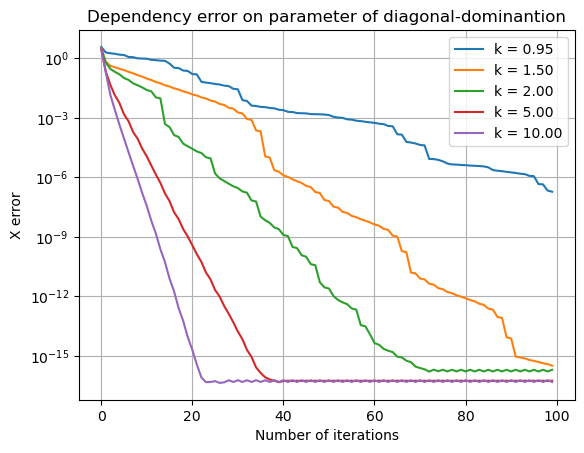

In [241]:
rndm = np.random.RandomState(999)
plt.figure()

n = 10

for k in (0.95, 1.5, 2, 5, 10):
    A_r = rndm.uniform(size=(n, n)) + np.diagflat([k]*n)
    b_r = rndm.uniform(size=n)
    N = 100
    x_r = np.zeros((N, n))
    x_r[0] = np.ones(n)
    x_true = np.linalg.solve(A_r, b_r)
    errx = np.ones(N)
    errr = np.ones(N)
    errx[0] = np.linalg.norm(x_r[0] - x_true)
    errr[0] = np.linalg.norm(A_r @ x_r[0] - b_r )
    
    for i in range(1,N):
        x_r[i] = res(A_r, b_r, x0=x_r[i-1], n_iter=1)
        errx[i] = np.linalg.norm(x_r[i] - x_true)
        errr[i] = np.linalg.norm(A_r @ x_r[i] - b_r )
    plt.plot(errx, label = r'k = %.2f' % k)
    #plt.plot(errr)
plt.legend()    
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('X error')
plt.title('Dependency error on parameter of diagonal-dominantion')
plt.yscale ('log')  